# Final Project

## Environment Setup

In [10]:
import os
from PIL import Image
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from transformers import AutoFeatureExtractor, AutoModel

## Custom DogVsAi Dataset Class

In [11]:
class DogVsAiDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.image_dir = os.path.join(root_dir, "Images")
        self.label_dir = os.path.join(root_dir, "Labels")
        self.transform = transform
        self.image_names = [f.split('.')[0] for f in os.listdir(self.image_dir) if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        name = self.image_names[idx]
        image_path = os.path.join(self.image_dir, name + '.jpg')
        label_path = os.path.join(self.label_dir, name + '.txt')

        image = Image.open(image_path).convert("RGB")
        if self.transform:
            image = self.transform(image)

        with open(label_path, 'r') as f:
            label = int(f.read().strip())

        return image, label

## ViT Feature Extractor Setup: Image Transformations and DINO Model Initialization

In [12]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

dino_model_name = "facebook/dino-vits16"
feature_extractor = AutoFeatureExtractor.from_pretrained(dino_model_name)
dino_model = AutoModel.from_pretrained(dino_model_name).to(device)
dino_model.eval()

preprocessor_config.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

/opt/anaconda3/envs/bayes1/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

Some weights of ViTModel were not initialized from the model checkpoint at facebook/dino-vits16 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTModel(
  (embeddings): ViTEmbeddings(
    (patch_embeddings): ViTPatchEmbeddings(
      (projection): Conv2d(3, 384, kernel_size=(16, 16), stride=(16, 16))
    )
    (dropout): Dropout(p=0.0, inplace=False)
  )
  (encoder): ViTEncoder(
    (layer): ModuleList(
      (0-11): 12 x ViTLayer(
        (attention): ViTAttention(
          (attention): ViTSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
          )
          (output): ViTSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.0, inplace=False)
          )
        )
        (intermediate): ViTIntermediate(
          (dense): Linear(in_features=384, out_features=1536, bias=True)
          (intermediate_act_fn): GELUActivation()
        )
        (output): ViTOutput(
          (d

model.safetensors:   0%|          | 0.00/86.7M [00:00<?, ?B/s]

## Feature Extraction Pipeline and Dataset Processing

In [31]:
# ======================
# Feature Engineering
# ======================
def extract_and_save_features(dataloader, name_prefix):
    all_features = []
    all_labels = []

    for images, labels in tqdm(dataloader, desc=f"Extracting {name_prefix}"):
        images = [transforms.ToPILImage()(img) for img in images]
        inputs = feature_extractor(images=images, return_tensors="pt", padding=True).to(device)

        with torch.no_grad():
            outputs = dino_model(**inputs)
            features = outputs.last_hidden_state.mean(dim=1)

        all_features.append(features.cpu())
        all_labels.append(labels)

    all_features = torch.cat(all_features)
    all_labels = torch.cat(all_labels)

    save_path = f"features_{name_prefix}.pt"
    torch.save((all_features, all_labels), save_path)
    print(f"Saved: {save_path} | Shape: {all_features.shape}")

# ======================
# Process dataset
# ======================
def process_dataset(base_path, suffix):
    print(f"\n=== Processing dataset: {suffix.upper()} ===")
    train_dataset = DogVsAiDataset(os.path.join(base_path, "Train"), transform=transform)
    val_dataset   = DogVsAiDataset(os.path.join(base_path, "Valid"), transform=transform)
    test_dataset  = DogVsAiDataset(os.path.join(base_path, "Test"), transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader   = DataLoader(val_dataset, batch_size=16, shuffle=False)
    test_loader  = DataLoader(test_dataset, batch_size=16, shuffle=False)

    print(f"Train: {len(train_dataset)} | Val: {len(val_dataset)} | Test: {len(test_dataset)}")

    extract_and_save_features(train_loader, f"train_{suffix}")
    extract_and_save_features(val_loader, f"val_{suffix}")
    extract_and_save_features(test_loader, f"test_{suffix}")

# ======================
# Get features
# ======================
process_dataset("yourpath/archive/Dogs Vs AiDogs", "full")
# process_dataset("yourpath/archive/Dogs Vs AiDogs_CUTTED", "cutted")


=== Processing dataset: FULL ===
Train: 18605 | Val: 5317 | Test: 2658


Extracting train_full:   0%|          | 0/1163 [00:00<?, ?it/s]/opt/anaconda3/envs/bayes1/lib/python3.10/site-packages/transformers/image_processing_utils.py:42: UserWarning: The following named arguments are not valid for `ViTFeatureExtractor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)
Extracting train_full: 100%|██████████| 1163/1163 [05:24<00:00,  3.59it/s]


Saved: features_train_full.pt | Shape: torch.Size([18605, 384])


Extracting val_full: 100%|██████████| 333/333 [01:35<00:00,  3.48it/s]


Saved: features_val_full.pt | Shape: torch.Size([5317, 384])


Extracting test_full: 100%|██████████| 167/167 [00:52<00:00,  3.15it/s]

Saved: features_test_full.pt | Shape: torch.Size([2658, 384])


In [34]:
features, labels = torch.load("features_train_full.pt")
print(features.shape)

torch.Size([18605, 384])


/var/folders/xw/skmf04z90jbgxhhy49sh07s80000gn/T/ipykernel_59783/202935973.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features, labels = torch.load("features_train_

# Simple CNN Architecture with Dropout

In [41]:
import torch.nn as nn
import torchvision.models as models

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(384, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rate),

            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.net(x)

def load_model(model_type="simple", num_classes=2, dropout_rate=0.5):
    return SimpleCNN(num_classes, dropout_rate)

# Simple CNN Model Training and Evaluation

/var/folders/xw/skmf04z90jbgxhhy49sh07s80000gn/T/ipykernel_59783/2562054780.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  features_train, labels_train = torch.load("fe

Epoch 1: Train Acc = 0.9468 | Val Acc = 0.9859
Epoch 2: Train Acc = 0.9718 | Val Acc = 0.9876
Epoch 3: Train Acc = 0.9768 | Val Acc = 0.9878
Epoch 4: Train Acc = 0.9787 | Val Acc = 0.9893
Epoch 5: Train Acc = 0.9804 | Val Acc = 0.9885
Epoch 6: Train Acc = 0.9810 | Val Acc = 0.9855
Epoch 7: Train Acc = 0.9839 | Val Acc = 0.9855
Epoch 8: Train Acc = 0.9840 | Val Acc = 0.9883
Epoch 9: Train Acc = 0.9855 | Val Acc = 0.9891
Epoch 10: Train Acc = 0.9859 | Val Acc = 0.9925


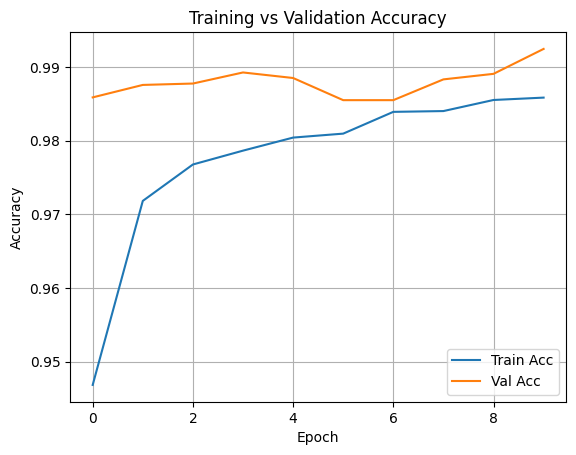

In [42]:
import torch.optim as optim
from torch.utils.data import TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# load features, labels, dataset
features_train, labels_train = torch.load("features_train_full.pt")
features_val, labels_val = torch.load("features_val_full.pt")

train_dataset = TensorDataset(features_train, labels_train)
val_dataset = TensorDataset(features_val, labels_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# load model
model = SimpleCNN(num_classes=2, dropout_rate=0.5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# training loop
train_acc_list = []
val_acc_list = []
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    train_preds, train_labels = [], []

    for batch_x, batch_y in train_loader:
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

        train_preds += outputs.argmax(dim=1).cpu().tolist()
        train_labels += batch_y.cpu().tolist()

    train_acc = accuracy_score(train_labels, train_preds)
    train_acc_list.append(train_acc)

    # validation
    model.eval()
    val_preds, val_labels = [], []
    with torch.no_grad():
        for batch_x, batch_y in val_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            val_preds += outputs.argmax(dim=1).cpu().tolist()
            val_labels += batch_y.cpu().tolist()

    val_acc = accuracy_score(val_labels, val_preds)
    val_acc_list.append(val_acc)

    print(f"Epoch {epoch+1}: Train Acc = {train_acc:.4f} | Val Acc = {val_acc:.4f}")

# save model
torch.save(model.state_dict(), "simple_cnn_model.pt")

# plot training and validation accuracy
plt.plot(train_acc_list, label="Train Acc")
plt.plot(val_acc_list, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.grid(True)
plt.show()

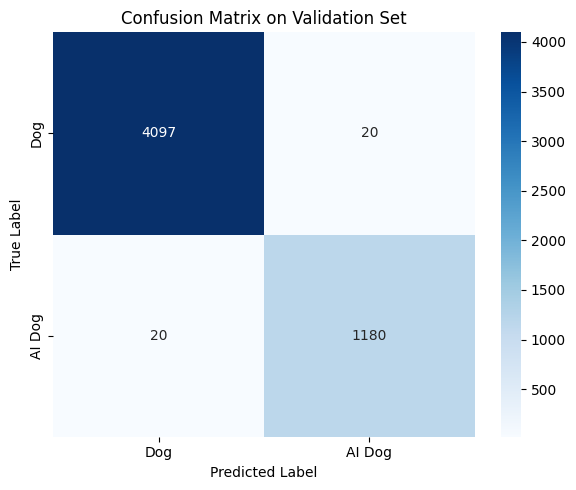

In [46]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns
import numpy as np

# confusion matrix
cm = confusion_matrix(val_labels, val_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Dog", "AI Dog"])

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Dog", "AI Dog"], yticklabels=["Dog", "AI Dog"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix on Validation Set")
plt.tight_layout()
plt.show()